<a href="https://colab.research.google.com/github/CaptainJimbo/MyPortfolio/blob/main/Solving_The_Three_Body_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table align="left">
  <td align="left">
  <a target="_blank" href="https://dimitriskogias.wixsite.com/spacecowboy" style="text-decoration: none; display: flex; align-items: center; color: white; background-color: purple; padding: 10px; border-radius: 5px;">
      <img src="https://static.wikia.nocookie.net/bravestarr/images/6/6d/Lucas_Conway.png/revision/latest?cb=20211111224054" width="40px" height="40px" style="border-radius: 50%; margin-right: 10px;" />
      <span>Visit my Webpage</span>
    </a>
  </td>
</table>



<table align="left">
  <td align="left"><a target="_blank" href="https://github.com/CaptainJimbo/MyPortfolio/blob/main/Solving_The_Three_Body_Problem.ipynb" style="text-decoration: none; display: flex; align-items: center; color: black; background-color: lightgray; padding: 10px; border-radius: 5px;">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  width="40px" height="40px" style="border-radius: 50%; margin-right: 10px;"   />View it on GitHub</a></td>
</table>


In [1]:
# Load libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import time


In [ ]:
# functions

def get_data(idx):
    x = np. array([data[idx,:,0],data[idx,:,3],data[idx,:,4]]).T   #t,x2,y2 shape=(time steps,3)
    y = np.array([data[idx,:,1],data[idx,:,2],data[idx,:,3],data[idx,:,4]]).T  #x1,y1,x2,y2 shape=(time steps,4)
    return x,y

def get_training_data(idx):
    data = training_data
    x = np. array([data[idx,:,0],data[idx,:,3],data[idx,:,4]]).T   #t,x2,y2 shape=(time steps,3)
    y = np.array([data[idx,:,1],data[idx,:,2],data[idx,:,3],data[idx,:,4]]).T  #x1,y1,x2,y2 shape=(time steps,4)
    return x,y

def get_trajectories(pred):
    # pred = x1,y1,x2,y2
    p1 = np. array([pred[:,0],pred[:,1]]).T
    p2 = np. array([pred[:,2],pred[:,3]]).T
    p3 = -p1 -p2  # x1 + x2 + x3 = 0 , y1 + y2 + y3 = 0
    return p1,p2,p3

def plot_trajectories(p1, p2, p3, ax=None, style = '-', leg = None, **kwargs):
    plt.plot(p1[:,0],p1[:,1],'r',linestyle = style , label = leg)
    plt.plot(p1[0,0],p1[0,1],'ro')
    plt.plot(p2[:,0],p2[:,1],'b',linestyle = style , label = leg)
    plt.plot(p2[0,0],p2[0,1],'bo')
    plt.plot(p3[:,0],p3[:,1],'g',linestyle = style , label = leg)
    plt.plot(p3[0,0],p3[0,1],'go') # bullets for initial conditions

    plt.legend(loc='best',fontsize='small');
    #return NotImplementedError #wtfisthis

def special_input(data,idx):
    t = data[idx,:,0]
    x2 = data[idx,:,3]*0 + data[idx,:,3][0] # 1000 element columns with the same initial position)
    y2 = data[idx,:,4]*0 + data[idx,:,4][0] # from get data function[0]= t,x2,y2
    return np.array([t,x2,y2]).T


In [ ]:
# Load and unpack a compressed npy array
load_data = np.load('data_project2.npz')
data = load_data['arr_0']
print(f'data.shape={data.shape}')
print(f'this guy has {data.shape[0]} samples of {data.shape[2]} columns of (t,x1,y1,x2,y2,ux1,uy1,ux2,uy2) and each one has {data.shape[1]} elements')

data.shape=(9000, 1000, 9)
this guy has 9000 samples of 9 columns of (t,x1,y1,x2,y2,ux1,uy1,ux2,uy2) and each one has 1000 elements


In [ ]:
# lets load the pre trained model and predict some trajectories
pre_trained_model = keras.models.load_model("Breen_NN_project2.h5")

In [ ]:
from sklearn.model_selection import train_test_split

#sample splitting
train_percentage = 0.9
training_data, validation_data = train_test_split(data ,train_size=train_percentage)
size = len(training_data)
input_data_unshaped = np.zeros(((size,1000,3)))# still (t,x2,y2)

# this special_input  fucntion that changes x2,y2 snapshots to x2_0,y2_0 everywhere
for idx in range(size):
    input_data_unshaped [idx] = special_input(training_data,idx)

# input data reshaping
train_input_data = input_data_unshaped.reshape(-1,3)
print(f'The training sample is the {train_percentage*100}% of data and has size {size}.\n \
\n\n - The shape of the unshaped input training sample is {input_data_unshaped.shape}, that is {size} samples of \
1000 snapshots of (t , x2(t)=x2_0 , y2(t)=y2_0). In order to have a valid training input we stack all samples \
by column and that changes the input training sample shape to {train_input_data.shape}.')

output_data_unshaped = training_data[:,:,:5][:,:,1:]
train_output_data = output_data_unshaped.reshape(-1,4)
print (f'\n - The shape of the unshaped output training sample is {output_data_unshaped.shape}. In order to have a\
 valid training output we stack all samples by column and that changes the output training sample \
shape to {train_output_data.shape}.')



val_percentage = 0.1
size = len(validation_data)
input_data_unshaped = np.zeros(((size,1000,3)))# still (t,x2,y2)

# this special_input  fucntion that changes x2,y2 snapshots to x2_0,y2_0 everywhere
for idx in range(size):
    input_data_unshaped [idx] = special_input(validation_data,idx)

# input data reshaping
val_input_data = input_data_unshaped.reshape(-1,3)
print(f'\n\n\nThe validation sample is the {val_percentage*100}% of data and has size  {size}.\n \
\n\n - The shape of the unshaped input validation sample is {input_data_unshaped.shape}, that is {size} samples of \
1000 snapshots of (t , x2(t)=x2_0 , y2(t)=y2_0). In order to have a valid validation input we stack all samples \
by column and that changes the input validation sample shape to {val_input_data.shape}.')

output_data_unshaped = validation_data[:,:,:5][:,:,1:]
val_output_data = output_data_unshaped.reshape(-1,4)
print (f'\n - The shape of the unshaped output validation sample is {output_data_unshaped.shape}. In order to have a\
 valid validation output we stack all samples by column and that changes the output validation sample \
shape to {val_output_data.shape}.')






The training sample is the 90.0% of data and has size 8100.
 

 - The shape of the unshaped input training sample is (8100, 1000, 3), that is 8100 samples of 1000 snapshots of (t , x2(t)=x2_0 , y2(t)=y2_0). In order to have a valid training input we stack all samples by column and that changes the input training sample shape to (8100000, 3).

 - The shape of the unshaped output training sample is (8100, 1000, 4). In order to have a valid training output we stack all samples by column and that changes the output training sample shape to (8100000, 4).



The validation sample is the 10.0% of data and has size  900.
 

 - The shape of the unshaped input validation sample is (900, 1000, 3), that is 900 samples of 1000 snapshots of (t , x2(t)=x2_0 , y2(t)=y2_0). In order to have a valid validation input we stack all samples by column and that changes the input validation sample shape to (900000, 3).

 - The shape of the unshaped output validation sample is (900, 1000, 4). In order to have a

In [ ]:
print(f' Recap: \n')
print(f' train_input_data.shape = {train_input_data.shape}\n train_output_data.shape = {train_output_data.shape} \n \
val_input_data.shape = {val_input_data.shape}\n val_output_data.shape = {val_output_data.shape} ')

 Recap: 

 train_input_data.shape = (8100000, 3)
 train_output_data.shape = (8100000, 4) 
 val_input_data.shape = (900000, 3)
 val_output_data.shape = (900000, 4) 


In [ ]:
# creating the data_sets

# my inputs/outputs have dimensions (8100000,3)/(8100000,4)
training_dataset = tf.data.Dataset.from_tensor_slices((train_input_data,train_output_data))

# my inputs/outputs have dimensions (900000,3)/(900000,4)
validation_dataset =  tf.data.Dataset.from_tensor_slices((val_input_data,val_output_data))

# batches of 5 samples (5*1000)
training_dataset = training_dataset.batch(5000)
validation_dataset = validation_dataset.batch(5000)

In [ ]:
# my Neural Network
myNN = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3)),  #input
    tf.keras.layers.Dense(128, activation='relu'), #1
    tf.keras.layers.Dense(128, activation='relu'), #2
    tf.keras.layers.Dense(128, activation='relu'), #3
    tf.keras.layers.Dense(128, activation='relu'), #4
    tf.keras.layers.Dense(128, activation='relu'), #5
    tf.keras.layers.Dense(128, activation='relu'), #6
    tf.keras.layers.Dense(128, activation='relu'), #7
    tf.keras.layers.Dense(128, activation='relu'), #8
    tf.keras.layers.Dense(128, activation='relu'), #9
    tf.keras.layers.Dense(128, activation='relu'), #10
    tf.keras.layers.Dense(4)                      #output
])

# summary
myNN.summary()

# compiler
myNN.compile(optimizer=keras.optimizers.Adam(0.001, 0.5, 0.5)
              ,loss=keras.losses.MeanAbsoluteError(),
              metrics=['mse'])



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1

In [ ]:
#training of myNN

start =  time.perf_counter()
result = myNN.fit_generator(training_dataset, epochs=100, validation_data = validation_dataset)
end = time.perf_counter()
total_time = end - start
print(f'total time is {round(total_time/60)} minutes')

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
1620/1620 [==============================] - 136s 84ms/step - loss: 0.2104 - mse: 0.1640 - val_loss: 0.1605 - val_mse: 0.1255
Epoch 2/100
1620/1620 [==============================] - 129s 80ms/step - loss: 0.1586 - mse: 0.1207 - val_loss: 0.1406 - val_mse: 0.1118
Epoch 3/100
1620/1620 [==============================] - 127s 79ms/step - loss: 0.1419 - mse: 0.1064 - val_loss: 0.1295 - val_mse: 0.0966
Epoch 4/100
1620/1620 [==============================] - 124s 76ms/step - loss: 0.1319 - mse: 0.1003 - val_loss: 0.1289 - val_mse: 0.1151
Epoch 5/100
1620/1620 [==============================] - 126s 78ms/step - loss: 0.1265 - mse: 0.0951 - val_loss: 0.1235 - val_mse: 0.1001
Epoch 6/100
1620/1620 [==============================] - 127s 78ms/step - loss: 0.1203 - mse: 0.0918 - val_loss: 0.1234 - val_mse: 0.0917
Epoch 7/100
1620/1620 [==============================] - 126s 78ms/step - loss: 0.1152 - mse: 0.

In [ ]:
#result.history

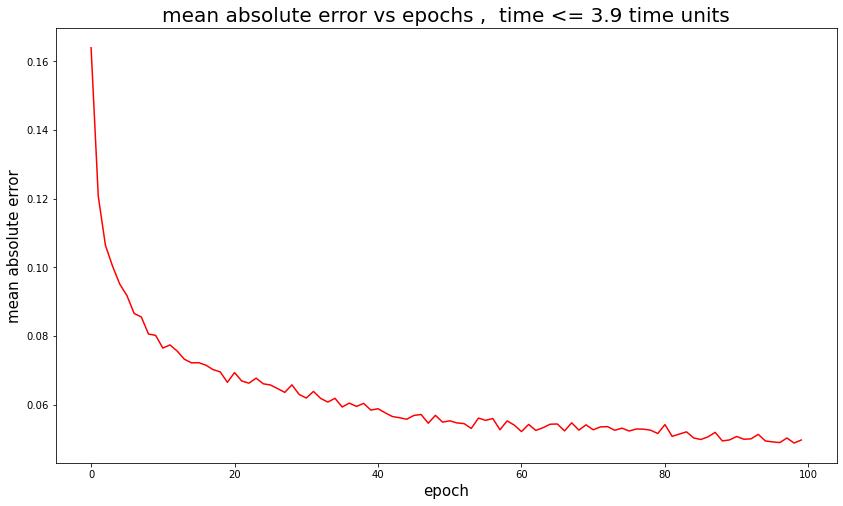

In [ ]:
# plotting mae vs epoch
result.history['mse']
plt.figure(figsize=(14,8))
plt.title('mean absolute error vs epochs ,  time <= 3.9 time units' ,size=20)
plt.plot(result.history['mse'],'r');
plt.xlabel('epoch',size=15)
plt.ylabel('mean absolute error',size=15);


             myNN                       pretrained

 [[ 5.5345751e-02  2.4519477e-02  1.0019426e+00  2.7676672e-04]
 [ 8.8206446e-01  5.9832204e-03  1.0017688e+00  3.4224242e-04]
 [ 9.9090767e-01 -1.9214975e-04  1.0015950e+00  4.0771812e-04]
 ...
 [ 9.2795724e-01 -1.0844976e+00  9.0909457e-01 -1.1513842e+00]
 [ 9.2887759e-01 -1.0845187e+00  9.0952486e-01 -1.1514581e+00]
 [ 9.2977995e-01 -1.0844997e+00  9.0995795e-01 -1.1515501e+00]]


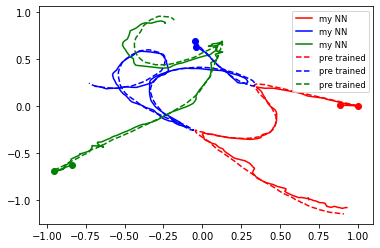

In [ ]:
# Lets compare my NN with the pre trained model from the paper

# i pick a random initial condition
idxrand = np.random.randint(9000)

# prediction for my NN nad plotting
predictions = myNN.predict( special_input(data, idxrand))
r1 , r2, r3 = get_trajectories(predictions)
# i discarded the first points of x1,y1,x2,y2, the x1,y1(0) was not (1,0) the x1,y1(1) was fine about (1,0)
plot_trajectories(r1[1:,:] , r2[1:,:] , r3[1:,:], ax=None , leg = 'my NN')
k1 = r1
# prediction for pre trained model and plotting
predictions = pre_trained_model.predict( special_input(data, idxrand))
r1 , r2 , r3 = get_trajectories(predictions)
plot_trajectories(r1, r2, r3, ax=None, style='--',leg = 'pre trained')
print(f'             myNN                       pretrained\n\n {np.hstack((k1,r1))}')

             predicted                       original

 [[1.00302553e+00 4.27059829e-04 1.00000000e+00 0.00000000e+00]
 [1.00289130e+00 4.49992716e-04 9.99991446e-01 6.46311228e-07]
 [1.00275731e+00 4.72895801e-04 9.99965782e-01 2.58521880e-06]
 ...
 [6.59429431e-01 2.75090307e-01 6.61986333e-01 2.79924042e-01]
 [6.57716334e-01 2.75127083e-01 6.60996570e-01 2.79949627e-01]
 [6.56039834e-01 2.75169045e-01 6.59970570e-01 2.79955592e-01]]


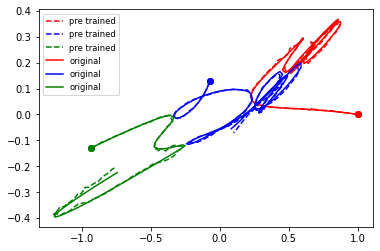

In [ ]:
predictions = pre_trained_model.predict( special_input(data, idxrand))
r1 , r2 , r3 = get_trajectories(predictions)
plot_trajectories(r1, r2, r3, ax=None, style ='--',leg = 'pre trained')
k1 = r1
r1 , r2 , r3 = get_trajectories(get_data(idxrand)[1])
plot_trajectories(r1, r2, r3, ax=None, style ='-', leg = 'original')
print(f'             predicted                       original\n\n {np.hstack((k1,r1))}')



In [ ]:
#from datetime import datetime
#now = datetime.now()
#current_datetime = now.strftime("%D,%H-%M-%S")
#name = 'myNN_mk2('+current_datetime+').h5'

# saving model
tf.keras.models.save_model(myNN, 'myNN_10_128.h5')